In [9]:
import pandas as pd
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.model_selection import GridSearchCV 

# Bibliotecas dos algoritmos
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [10]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
df = pd.read_csv("proteins_features_cerevisiae.csv")
df

,Protein_key,DegreeCentrality,EigenvectorCentrality,BetweennessCentrality,ClosenessCentrality,Clustering,is_essential
0,4932.YBR182C,0.059909,0.009397,1.233359e-04,0.499687,0.313084,0
1,4932.YMR158W,0.090568,0.023854,7.005906e-05,0.506416,0.479887,0
2,4932.YKL023W,0.008603,0.001296,1.071163e-05,0.462122,0.236364,0
3,4932.YLR054C,0.006257,0.000445,7.120056e-06,0.443589,0.289744,0
4,4932.YGL216W,0.083060,0.012795,2.988854e-04,0.506938,0.273937,0
...,...,...,...,...,...,...,...
6389,4932.YMR010W,0.020648,0.002403,4.499981e-05,0.475918,0.193847,0
6390,4932.YMR026C,0.043172,0.005179,1.245902e-04,0.491845,0.181686,0
6391,4932.YMR244W,0.002972,0.000226,3.814570e-07,0.395925,0.233918,0
6392,4932.YDL113C,0.041764,0.004499,8.969398e-05,0.486937,0.242178,0


## Análise Exploratória

In [4]:
df.describe()

,DegreeCentrality,EigenvectorCentrality,BetweennessCentrality,ClosenessCentrality,Clustering,is_essential
count,6394.000000,6.394000e+03,6394.000000,6394.000000,6394.000000,6394.000000
mean,0.048648,8.576647e-03,0.000175,0.477158,0.281981,0.172036
std,0.042128,9.102237e-03,0.000572,0.043545,0.130878,0.377441
min,0.000156,1.045283e-09,0.000000,0.228183,0.000000,0.000000
25%,0.015955,1.728928e-03,0.000026,0.469357,0.207778,0.000000
50%,0.037072,5.143851e-03,0.000086,0.487531,0.255808,0.000000
75%,0.072540,1.268751e-02,0.000200,0.502318,0.323857,0.000000
max,0.426873,5.201734e-02,0.032784,0.629294,1.000000,1.000000


In [12]:
df['is_essential'].value_counts()

0    5294
1    1100
Name: is_essential, dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6394 entries, 0 to 6393
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Protein_key            6394 non-null   object 
 1   DegreeCentrality       6394 non-null   float64
 2   EigenvectorCentrality  6394 non-null   float64
 3   BetweennessCentrality  6394 non-null   float64
 4   ClosenessCentrality    6394 non-null   float64
 5   Clustering             6394 non-null   float64
 6   is_essential           6394 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 349.8+ KB


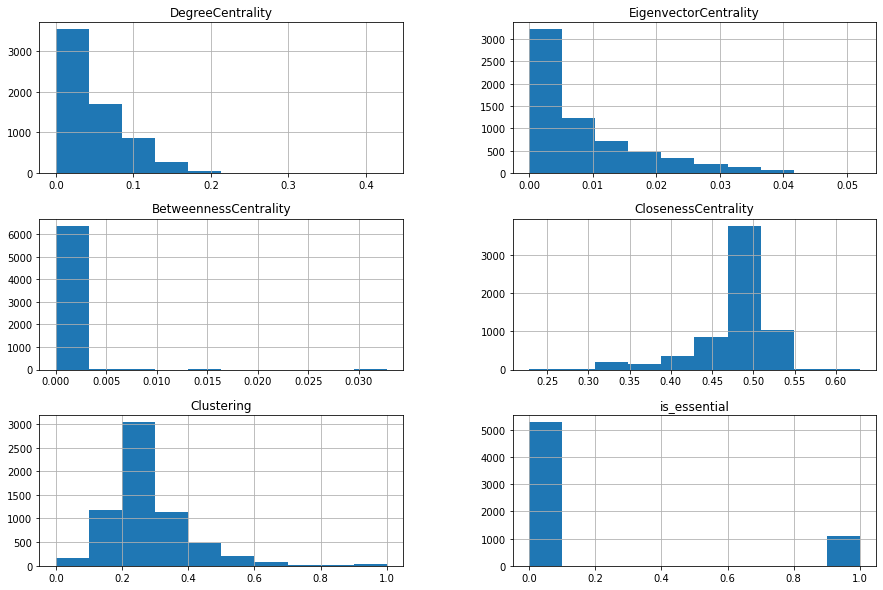

In [6]:
# Histograma
df.hist(figsize = (15,10))

#sns.histplot(data=df, hue="is_essential")
plt.show()

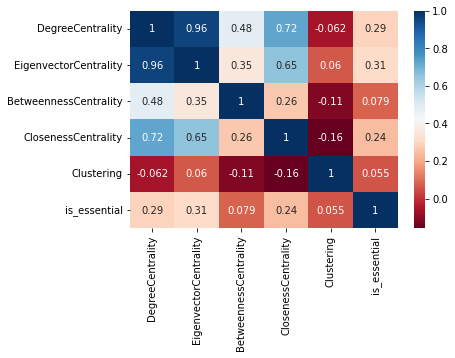

In [7]:
# Matriz de Correlação com Matplotlib Seaborn
sns.heatmap(df.corr(), annot=True, cmap='RdBu');

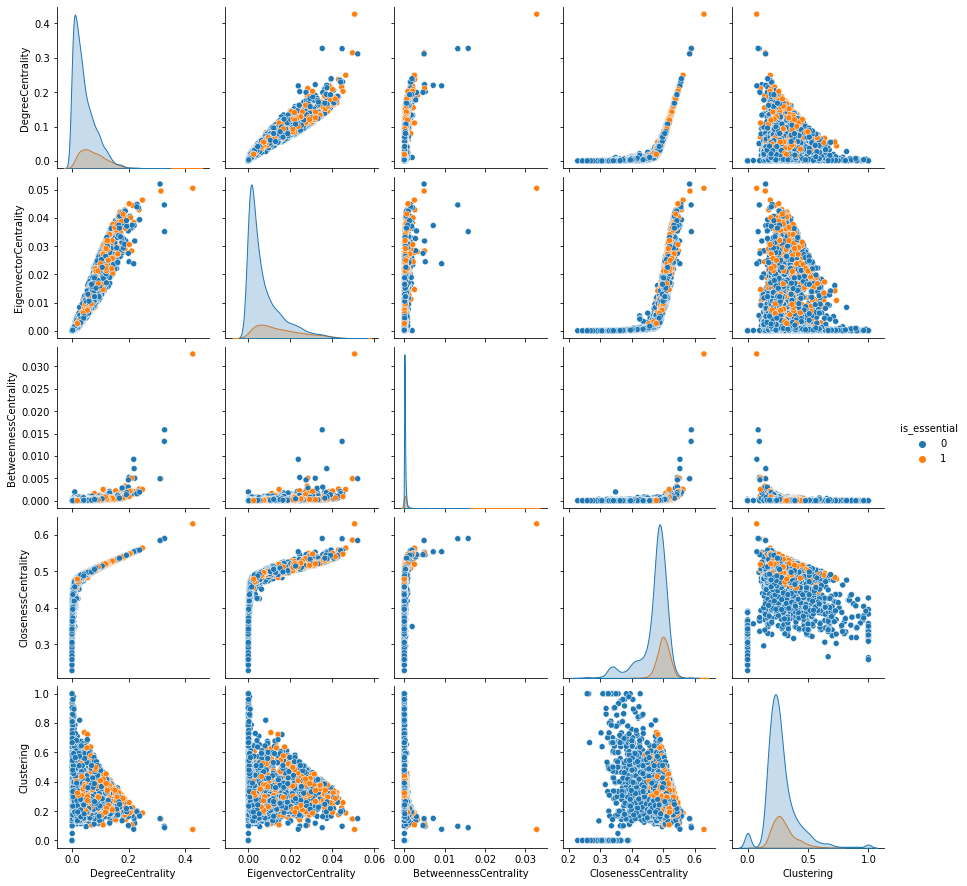

In [8]:
# Scatter Plot com Seaborn 

sns.pairplot(df, hue = "is_essential");

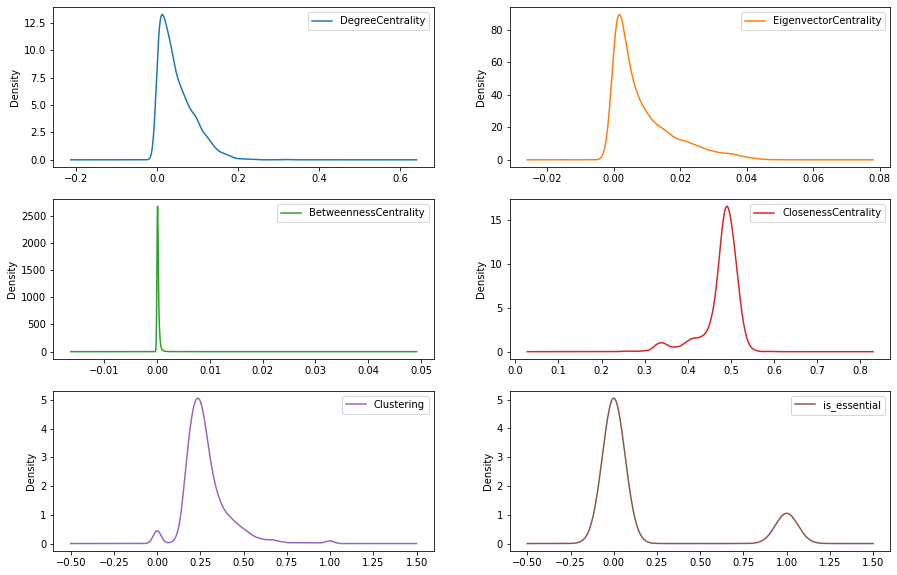

In [10]:
# Density Plot
df.plot(kind = 'density', subplots = True, layout = (3,2), sharex = False, figsize = (15,10))
plt.show()

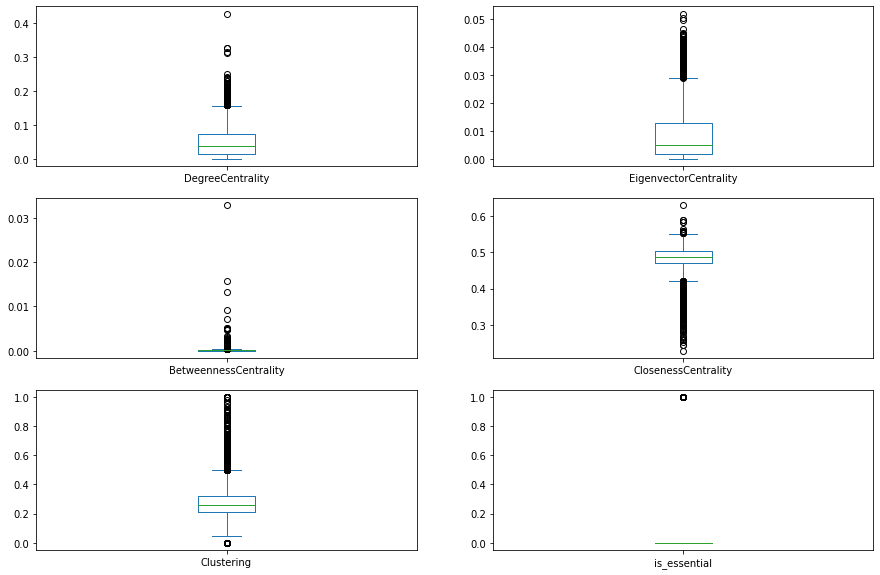

In [11]:
# Boxplot
df.plot(kind = 'box', subplots = True, layout = (3,2), sharex = False, sharey = False, figsize = (15,10))
plt.show()

In [7]:
# Separação em conjuntos de treino e teste
X = df.drop(['Protein_key','is_essential'], axis=1)
y = df['is_essential']
test_size = 0.3
seed = 7
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=test_size, 
                                                    random_state=seed,
                                                    shuffle=True, 
                                                    stratify=y)
y_train.value_counts()

0    3705
1     770
Name: is_essential, dtype: int64

In [8]:
## Oversampling
oversample = SMOTE()

X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

y_train_smote.value_counts()

1    3705
0    3705
Name: is_essential, dtype: int64

In [9]:
## Undersampling

undersample = RandomUnderSampler()

X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)

y_train_under.value_counts()

0    770
1    770
Name: is_essential, dtype: int64

## Classificadores - Gridsearch

In [51]:

# definindo a métrica de avaliação dos algoritmos
#scoring = 'accuracy'
scoring = 'roc_auc'

num_particoes = 10 # número de folds da validação cruzada

kfold = StratifiedKFold(n_splits=num_particoes)

In [52]:
def gridsearch(X_train, y_train, model, param_grid, scoring, kfold):
    
    # busca exaustiva de hiperparâmetros com GridSearchCV
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid_result = grid.fit(X_train, y_train)

    # imprime o melhor resultado
    print("Melhor: %f usando %s" % (grid_result.best_score_, grid_result.best_params_)) 

    # imprime todos os resultados
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f): %r" % (mean, stdev, param))
        

## KNN

In [53]:
# Tuning do KNN

# hiperparâmetros que serão avaliados
k = range(1,20)
distancias = ["euclidean", "manhattan", "minkowski"]
param_grid = dict(n_neighbors=k, metric=distancias)

# modelo
model = KNeighborsClassifier()

In [54]:
# Dados Originais

gridsearch(X_train, y_train, model, param_grid, scoring, kfold)
# Melhor: 0.831283 usando {'metric': 'euclidean', 'n_neighbors': 18}

Melhor: 0.719307 usando {'metric': 'euclidean', 'n_neighbors': 19}
0.586471 (0.019738): {'metric': 'euclidean', 'n_neighbors': 1}
0.617298 (0.022016): {'metric': 'euclidean', 'n_neighbors': 2}
0.639652 (0.018703): {'metric': 'euclidean', 'n_neighbors': 3}
0.659439 (0.021726): {'metric': 'euclidean', 'n_neighbors': 4}
0.668000 (0.024360): {'metric': 'euclidean', 'n_neighbors': 5}
0.672865 (0.024839): {'metric': 'euclidean', 'n_neighbors': 6}
0.680577 (0.023443): {'metric': 'euclidean', 'n_neighbors': 7}
0.687584 (0.026214): {'metric': 'euclidean', 'n_neighbors': 8}
0.695438 (0.028347): {'metric': 'euclidean', 'n_neighbors': 9}
0.699359 (0.026288): {'metric': 'euclidean', 'n_neighbors': 10}
0.705577 (0.025421): {'metric': 'euclidean', 'n_neighbors': 11}
0.706143 (0.025303): {'metric': 'euclidean', 'n_neighbors': 12}
0.708770 (0.024373): {'metric': 'euclidean', 'n_neighbors': 13}
0.714222 (0.025107): {'metric': 'euclidean', 'n_neighbors': 14}
0.715962 (0.022432): {'metric': 'euclidean', '

In [55]:
# SMOTE com Oversampling

gridsearch(X_train_smote, y_train_smote, model, param_grid, scoring, kfold)

# Melhor: 0.835762 usando {'metric': 'manhattan', 'n_neighbors': 1}

Melhor: 0.878681 usando {'metric': 'manhattan', 'n_neighbors': 4}
0.835625 (0.009682): {'metric': 'euclidean', 'n_neighbors': 1}
0.865856 (0.006815): {'metric': 'euclidean', 'n_neighbors': 2}
0.875062 (0.009261): {'metric': 'euclidean', 'n_neighbors': 3}
0.876837 (0.010716): {'metric': 'euclidean', 'n_neighbors': 4}
0.876719 (0.010958): {'metric': 'euclidean', 'n_neighbors': 5}
0.873686 (0.012267): {'metric': 'euclidean', 'n_neighbors': 6}
0.869306 (0.012797): {'metric': 'euclidean', 'n_neighbors': 7}
0.864737 (0.013965): {'metric': 'euclidean', 'n_neighbors': 8}
0.861798 (0.015217): {'metric': 'euclidean', 'n_neighbors': 9}
0.859144 (0.016027): {'metric': 'euclidean', 'n_neighbors': 10}
0.855345 (0.017248): {'metric': 'euclidean', 'n_neighbors': 11}
0.851979 (0.017702): {'metric': 'euclidean', 'n_neighbors': 12}
0.848740 (0.018282): {'metric': 'euclidean', 'n_neighbors': 13}
0.846182 (0.018779): {'metric': 'euclidean', 'n_neighbors': 14}
0.843591 (0.019210): {'metric': 'euclidean', 'n

In [56]:
# SMOTE com Undersampling

gridsearch(X_train_under, y_train_under, model, param_grid, scoring, kfold)

# Melhor: 0.674675 usando {'metric': 'euclidean', 'n_neighbors': 19}

Melhor: 0.732004 usando {'metric': 'euclidean', 'n_neighbors': 19}
0.620779 (0.032233): {'metric': 'euclidean', 'n_neighbors': 1}
0.662228 (0.057716): {'metric': 'euclidean', 'n_neighbors': 2}
0.675451 (0.055525): {'metric': 'euclidean', 'n_neighbors': 3}
0.686541 (0.049635): {'metric': 'euclidean', 'n_neighbors': 4}
0.691339 (0.051518): {'metric': 'euclidean', 'n_neighbors': 5}
0.702041 (0.052734): {'metric': 'euclidean', 'n_neighbors': 6}
0.706451 (0.049652): {'metric': 'euclidean', 'n_neighbors': 7}
0.707733 (0.046015): {'metric': 'euclidean', 'n_neighbors': 8}
0.712844 (0.042500): {'metric': 'euclidean', 'n_neighbors': 9}
0.711182 (0.038958): {'metric': 'euclidean', 'n_neighbors': 10}
0.710272 (0.037369): {'metric': 'euclidean', 'n_neighbors': 11}
0.713611 (0.038035): {'metric': 'euclidean', 'n_neighbors': 12}
0.718367 (0.040017): {'metric': 'euclidean', 'n_neighbors': 13}
0.719565 (0.038198): {'metric': 'euclidean', 'n_neighbors': 14}
0.720889 (0.035570): {'metric': 'euclidean', '

## Support Vector Machines

In [57]:
# Tuning do SVM

# hiperparâmetros que serão avaliados
c_values = np.arange (0.1, 2.1, 0.1)
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = dict(C=c_values, kernel=kernel_values)

# modelo
model = SVC()

In [58]:
# Dados Originais

gridsearch(X_train, y_train, model, param_grid, scoring, kfold)

# Melhor: 0.827933 usando {'C': 0.1, 'kernel': 'linear'}

Melhor: 0.731337 usando {'C': 0.8, 'kernel': 'linear'}
0.640944 (0.061771): {'C': 0.1, 'kernel': 'linear'}
0.674039 (0.060040): {'C': 0.1, 'kernel': 'poly'}
0.549534 (0.091502): {'C': 0.1, 'kernel': 'rbf'}
0.267078 (0.031986): {'C': 0.1, 'kernel': 'sigmoid'}
0.693002 (0.039571): {'C': 0.2, 'kernel': 'linear'}
0.661094 (0.066716): {'C': 0.2, 'kernel': 'poly'}
0.585985 (0.076370): {'C': 0.2, 'kernel': 'rbf'}
0.267071 (0.031989): {'C': 0.2, 'kernel': 'sigmoid'}
0.695527 (0.041384): {'C': 0.30000000000000004, 'kernel': 'linear'}
0.623292 (0.037147): {'C': 0.30000000000000004, 'kernel': 'poly'}
0.584027 (0.083246): {'C': 0.30000000000000004, 'kernel': 'rbf'}
0.267071 (0.031989): {'C': 0.30000000000000004, 'kernel': 'sigmoid'}
0.709930 (0.029556): {'C': 0.4, 'kernel': 'linear'}
0.662032 (0.061142): {'C': 0.4, 'kernel': 'poly'}
0.655344 (0.039071): {'C': 0.4, 'kernel': 'rbf'}
0.267057 (0.031996): {'C': 0.4, 'kernel': 'sigmoid'}
0.696510 (0.056757): {'C': 0.5, 'kernel': 'linear'}
0.627864 (0.0

In [59]:
# SMOTE com Oversampling

gridsearch(X_train_smote, y_train_smote, model, param_grid, scoring, kfold)

# Melhor: 0.697031 usando {'C': 0.5, 'kernel': 'rbf'}

Melhor: 0.753476 usando {'C': 0.1, 'kernel': 'poly'}
0.729070 (0.022995): {'C': 0.1, 'kernel': 'linear'}
0.753476 (0.025022): {'C': 0.1, 'kernel': 'poly'}
0.751544 (0.024631): {'C': 0.1, 'kernel': 'rbf'}
0.264947 (0.024247): {'C': 0.1, 'kernel': 'sigmoid'}
0.737913 (0.024558): {'C': 0.2, 'kernel': 'linear'}
0.752043 (0.024877): {'C': 0.2, 'kernel': 'poly'}
0.752236 (0.024642): {'C': 0.2, 'kernel': 'rbf'}
0.260261 (0.025468): {'C': 0.2, 'kernel': 'sigmoid'}
0.740867 (0.025316): {'C': 0.30000000000000004, 'kernel': 'linear'}
0.750144 (0.024949): {'C': 0.30000000000000004, 'kernel': 'poly'}
0.752424 (0.024497): {'C': 0.30000000000000004, 'kernel': 'rbf'}
0.259516 (0.025985): {'C': 0.30000000000000004, 'kernel': 'sigmoid'}
0.742494 (0.025757): {'C': 0.4, 'kernel': 'linear'}
0.748320 (0.024696): {'C': 0.4, 'kernel': 'poly'}
0.752564 (0.024440): {'C': 0.4, 'kernel': 'rbf'}
0.259820 (0.025942): {'C': 0.4, 'kernel': 'sigmoid'}
0.743160 (0.025821): {'C': 0.5, 'kernel': 'linear'}
0.746924 (0.024

In [60]:
# SMOTE com Undersampling

gridsearch(X_train_under, y_train_under, model, param_grid, scoring, kfold)

# Melhor: 0.692857 usando {'C': 1.4000000000000001, 'kernel': 'rbf'}

Melhor: 0.754292 usando {'C': 0.2, 'kernel': 'poly'}
0.704571 (0.031118): {'C': 0.1, 'kernel': 'linear'}
0.753921 (0.035972): {'C': 0.1, 'kernel': 'poly'}
0.745944 (0.034771): {'C': 0.1, 'kernel': 'rbf'}
0.270130 (0.028249): {'C': 0.1, 'kernel': 'sigmoid'}
0.717861 (0.029117): {'C': 0.2, 'kernel': 'linear'}
0.754292 (0.035752): {'C': 0.2, 'kernel': 'poly'}
0.749519 (0.037157): {'C': 0.2, 'kernel': 'rbf'}
0.270130 (0.028249): {'C': 0.2, 'kernel': 'sigmoid'}
0.725738 (0.030718): {'C': 0.30000000000000004, 'kernel': 'linear'}
0.754276 (0.036487): {'C': 0.30000000000000004, 'kernel': 'poly'}
0.750632 (0.038238): {'C': 0.30000000000000004, 'kernel': 'rbf'}
0.270130 (0.028249): {'C': 0.30000000000000004, 'kernel': 'sigmoid'}
0.728824 (0.031133): {'C': 0.4, 'kernel': 'linear'}
0.753803 (0.036961): {'C': 0.4, 'kernel': 'poly'}
0.751122 (0.038309): {'C': 0.4, 'kernel': 'rbf'}
0.269793 (0.028554): {'C': 0.4, 'kernel': 'sigmoid'}
0.731472 (0.031265): {'C': 0.5, 'kernel': 'linear'}
0.753466 (0.036

## RandomForest

In [61]:
# Tunning RandomForest

# hiperparâmetros que serão avaliados
param_grid = dict(max_depth = range(1,6),
                  max_features = range(1,6), 
                  bootstrap = [True, False],
                  criterion = ["gini", "entropy"],
                  n_estimators= range(5,20))

model = RandomForestClassifier()

In [62]:
# Dados Originais

gridsearch(X_train, y_train, model, param_grid, scoring, kfold)

# Melhor: 0.832180 usando {'bootstrap': True, 'criterion': 'gini', 
#'max_depth': 5, 'max_features': 5, 'n_estimators': 19}

Melhor: 0.754157 usando {'bootstrap': True, 'criterion': 'gini', 'max_depth': 3, 'max_features': 5, 'n_estimators': 18}
0.682685 (0.036023): {'bootstrap': True, 'criterion': 'gini', 'max_depth': 1, 'max_features': 1, 'n_estimators': 5}
0.684552 (0.036976): {'bootstrap': True, 'criterion': 'gini', 'max_depth': 1, 'max_features': 1, 'n_estimators': 6}
0.695056 (0.031197): {'bootstrap': True, 'criterion': 'gini', 'max_depth': 1, 'max_features': 1, 'n_estimators': 7}
0.699249 (0.036378): {'bootstrap': True, 'criterion': 'gini', 'max_depth': 1, 'max_features': 1, 'n_estimators': 8}
0.709441 (0.029062): {'bootstrap': True, 'criterion': 'gini', 'max_depth': 1, 'max_features': 1, 'n_estimators': 9}
0.707747 (0.029619): {'bootstrap': True, 'criterion': 'gini', 'max_depth': 1, 'max_features': 1, 'n_estimators': 10}
0.708020 (0.027592): {'bootstrap': True, 'criterion': 'gini', 'max_depth': 1, 'max_features': 1, 'n_estimators': 11}
0.697986 (0.033915): {'bootstrap': True, 'criterion': 'gini', 'max

In [63]:
# SMOTE com Oversampling

gridsearch(X_train_smote, y_train_smote, model, param_grid, scoring, kfold)

# Melhor: 0.719838 usando {'bootstrap': True, 'criterion': 'gini', 
#'max_depth': 5, 'max_features': 5, 'n_estimators': 13}

Melhor: 0.791978 usando {'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'max_features': 5, 'n_estimators': 13}
0.711797 (0.030964): {'bootstrap': True, 'criterion': 'gini', 'max_depth': 1, 'max_features': 1, 'n_estimators': 5}
0.713324 (0.024074): {'bootstrap': True, 'criterion': 'gini', 'max_depth': 1, 'max_features': 1, 'n_estimators': 6}
0.707181 (0.025074): {'bootstrap': True, 'criterion': 'gini', 'max_depth': 1, 'max_features': 1, 'n_estimators': 7}
0.721674 (0.024916): {'bootstrap': True, 'criterion': 'gini', 'max_depth': 1, 'max_features': 1, 'n_estimators': 8}
0.721584 (0.026789): {'bootstrap': True, 'criterion': 'gini', 'max_depth': 1, 'max_features': 1, 'n_estimators': 9}
0.724918 (0.027545): {'bootstrap': True, 'criterion': 'gini', 'max_depth': 1, 'max_features': 1, 'n_estimators': 10}
0.721179 (0.024639): {'bootstrap': True, 'criterion': 'gini', 'max_depth': 1, 'max_features': 1, 'n_estimators': 11}
0.729529 (0.029358): {'bootstrap': True, 'criterion': 'gini', 'max

In [64]:
# SMOTE com Undersampling

gridsearch(X_train_under, y_train_under, model, param_grid, scoring, kfold)

# Melhor: 0.706494 usando {'bootstrap': False, 'criterion': 'entropy',
#'max_depth': 3, 'max_features': 3, 'n_estimators': 9}

Melhor: 0.760643 usando {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 4, 'max_features': 2, 'n_estimators': 8}
0.699612 (0.034490): {'bootstrap': True, 'criterion': 'gini', 'max_depth': 1, 'max_features': 1, 'n_estimators': 5}
0.719379 (0.034318): {'bootstrap': True, 'criterion': 'gini', 'max_depth': 1, 'max_features': 1, 'n_estimators': 6}
0.719877 (0.033124): {'bootstrap': True, 'criterion': 'gini', 'max_depth': 1, 'max_features': 1, 'n_estimators': 7}
0.717355 (0.036644): {'bootstrap': True, 'criterion': 'gini', 'max_depth': 1, 'max_features': 1, 'n_estimators': 8}
0.717026 (0.035567): {'bootstrap': True, 'criterion': 'gini', 'max_depth': 1, 'max_features': 1, 'n_estimators': 9}
0.728900 (0.029963): {'bootstrap': True, 'criterion': 'gini', 'max_depth': 1, 'max_features': 1, 'n_estimators': 10}
0.722491 (0.041435): {'bootstrap': True, 'criterion': 'gini', 'max_depth': 1, 'max_features': 1, 'n_estimators': 11}
0.720855 (0.034136): {'bootstrap': True, 'criterion': 'gini', 'm

## Decision Tree

In [65]:
# Tunning DecisionTreeClassifier

# hiperparâmetros que serão avaliados
param_grid = dict(max_depth = range(1,6),
                  max_features = range(1,6), 
                  criterion = ["gini", "entropy"])

model = DecisionTreeClassifier()

In [66]:
# Dados Originais

gridsearch(X_train, y_train, model, param_grid, scoring, kfold)

# Melhor: 0.829722 usando {'criterion': 'gini', 'max_depth': 3, 'max_features': 1}

Melhor: 0.741072 usando {'criterion': 'gini', 'max_depth': 4, 'max_features': 2}
0.640889 (0.044043): {'criterion': 'gini', 'max_depth': 1, 'max_features': 1}
0.652662 (0.030756): {'criterion': 'gini', 'max_depth': 1, 'max_features': 2}
0.672171 (0.026741): {'criterion': 'gini', 'max_depth': 1, 'max_features': 3}
0.664030 (0.028567): {'criterion': 'gini', 'max_depth': 1, 'max_features': 4}
0.678605 (0.017256): {'criterion': 'gini', 'max_depth': 1, 'max_features': 5}
0.701361 (0.025657): {'criterion': 'gini', 'max_depth': 2, 'max_features': 1}
0.720290 (0.027836): {'criterion': 'gini', 'max_depth': 2, 'max_features': 2}
0.707923 (0.023675): {'criterion': 'gini', 'max_depth': 2, 'max_features': 3}
0.723361 (0.017594): {'criterion': 'gini', 'max_depth': 2, 'max_features': 4}
0.726284 (0.015109): {'criterion': 'gini', 'max_depth': 2, 'max_features': 5}
0.704559 (0.028500): {'criterion': 'gini', 'max_depth': 3, 'max_features': 1}
0.728885 (0.019739): {'criterion': 'gini', 'max_depth': 3, 'm

In [67]:
# SMOTE com Oversampling

gridsearch(X_train_smote, y_train_smote, model, param_grid, scoring, kfold)

# Melhor: 0.708097 usando {'criterion': 'gini', 'max_depth': 5, 'max_features': 4}

Melhor: 0.769000 usando {'criterion': 'gini', 'max_depth': 5, 'max_features': 4}
0.607548 (0.046548): {'criterion': 'gini', 'max_depth': 1, 'max_features': 1}
0.656575 (0.023318): {'criterion': 'gini', 'max_depth': 1, 'max_features': 2}
0.659660 (0.020742): {'criterion': 'gini', 'max_depth': 1, 'max_features': 3}
0.659503 (0.018808): {'criterion': 'gini', 'max_depth': 1, 'max_features': 4}
0.656512 (0.016469): {'criterion': 'gini', 'max_depth': 1, 'max_features': 5}
0.685302 (0.029471): {'criterion': 'gini', 'max_depth': 2, 'max_features': 1}
0.720449 (0.026609): {'criterion': 'gini', 'max_depth': 2, 'max_features': 2}
0.723617 (0.021154): {'criterion': 'gini', 'max_depth': 2, 'max_features': 3}
0.719320 (0.021875): {'criterion': 'gini', 'max_depth': 2, 'max_features': 4}
0.717447 (0.020801): {'criterion': 'gini', 'max_depth': 2, 'max_features': 5}
0.731494 (0.024445): {'criterion': 'gini', 'max_depth': 3, 'max_features': 1}
0.744288 (0.029779): {'criterion': 'gini', 'max_depth': 3, 'm

In [68]:
# SMOTE com Undersampling

gridsearch(X_train_under, y_train_under, model, param_grid, scoring, kfold)

# Melhor: 0.700649 usando {'criterion': 'entropy', 'max_depth': 4, 'max_features': 5}

Melhor: 0.738388 usando {'criterion': 'entropy', 'max_depth': 4, 'max_features': 3}
0.611688 (0.061108): {'criterion': 'gini', 'max_depth': 1, 'max_features': 1}
0.654545 (0.030430): {'criterion': 'gini', 'max_depth': 1, 'max_features': 2}
0.653247 (0.036756): {'criterion': 'gini', 'max_depth': 1, 'max_features': 3}
0.655844 (0.031006): {'criterion': 'gini', 'max_depth': 1, 'max_features': 4}
0.649351 (0.025647): {'criterion': 'gini', 'max_depth': 1, 'max_features': 5}
0.698963 (0.031702): {'criterion': 'gini', 'max_depth': 2, 'max_features': 1}
0.708678 (0.040705): {'criterion': 'gini', 'max_depth': 2, 'max_features': 2}
0.716833 (0.037095): {'criterion': 'gini', 'max_depth': 2, 'max_features': 3}
0.704697 (0.027190): {'criterion': 'gini', 'max_depth': 2, 'max_features': 4}
0.705229 (0.026425): {'criterion': 'gini', 'max_depth': 2, 'max_features': 5}
0.710347 (0.040277): {'criterion': 'gini', 'max_depth': 3, 'max_features': 1}
0.708829 (0.032602): {'criterion': 'gini', 'max_depth': 3,

## Logistic Regression

In [69]:
# Logistic Regression

# hiperparâmetros que serão avaliados
param_grid = dict(solver = ["lbfgs", "liblinear"],
             C = np.arange (0.1, 2.1, 0.1))

model = LogisticRegression()

In [70]:
# Dados Originais

gridsearch(X_train, y_train, model, param_grid, scoring, kfold)

# Melhor: 0.827933 usando {'C': 0.1, 'solver': 'lbfgs'}

Melhor: 0.735994 usando {'C': 2.0, 'solver': 'lbfgs'}
0.716107 (0.023805): {'C': 0.1, 'solver': 'lbfgs'}
0.718163 (0.022724): {'C': 0.1, 'solver': 'liblinear'}
0.724743 (0.023849): {'C': 0.2, 'solver': 'lbfgs'}
0.724405 (0.023255): {'C': 0.2, 'solver': 'liblinear'}
0.728388 (0.024501): {'C': 0.30000000000000004, 'solver': 'lbfgs'}
0.727549 (0.023604): {'C': 0.30000000000000004, 'solver': 'liblinear'}
0.730259 (0.024716): {'C': 0.4, 'solver': 'lbfgs'}
0.729130 (0.024194): {'C': 0.4, 'solver': 'liblinear'}
0.731447 (0.024764): {'C': 0.5, 'solver': 'lbfgs'}
0.730273 (0.024590): {'C': 0.5, 'solver': 'liblinear'}
0.732162 (0.025017): {'C': 0.6, 'solver': 'lbfgs'}
0.730907 (0.024735): {'C': 0.6, 'solver': 'liblinear'}
0.732639 (0.025146): {'C': 0.7000000000000001, 'solver': 'lbfgs'}
0.731524 (0.024817): {'C': 0.7000000000000001, 'solver': 'liblinear'}
0.733200 (0.025270): {'C': 0.8, 'solver': 'lbfgs'}
0.732008 (0.024919): {'C': 0.8, 'solver': 'liblinear'}
0.733515 (0.025304): {'C': 0.9, 'sol

In [71]:
# SMOTE com Oversampling

gridsearch(X_train_smote, y_train_smote, model, param_grid, scoring, kfold)

# Melhor: 0.670175 usando {'C': 2.0, 'solver': 'lbfgs'}

Melhor: 0.746387 usando {'C': 2.0, 'solver': 'lbfgs'}
0.733732 (0.023988): {'C': 0.1, 'solver': 'lbfgs'}
0.733284 (0.023791): {'C': 0.1, 'solver': 'liblinear'}
0.739889 (0.025219): {'C': 0.2, 'solver': 'lbfgs'}
0.739045 (0.024949): {'C': 0.2, 'solver': 'liblinear'}
0.742107 (0.025708): {'C': 0.30000000000000004, 'solver': 'lbfgs'}
0.741158 (0.025560): {'C': 0.30000000000000004, 'solver': 'liblinear'}
0.743237 (0.026023): {'C': 0.4, 'solver': 'lbfgs'}
0.742321 (0.025818): {'C': 0.4, 'solver': 'liblinear'}
0.743910 (0.026150): {'C': 0.5, 'solver': 'lbfgs'}
0.742986 (0.025966): {'C': 0.5, 'solver': 'liblinear'}
0.744359 (0.026213): {'C': 0.6, 'solver': 'lbfgs'}
0.743509 (0.026085): {'C': 0.6, 'solver': 'liblinear'}
0.744691 (0.026338): {'C': 0.7000000000000001, 'solver': 'lbfgs'}
0.743931 (0.026174): {'C': 0.7000000000000001, 'solver': 'liblinear'}
0.744946 (0.026398): {'C': 0.8, 'solver': 'lbfgs'}
0.744203 (0.026264): {'C': 0.8, 'solver': 'liblinear'}
0.745170 (0.026434): {'C': 0.9, 'sol

In [72]:
# SMOTE com Undersampling

gridsearch(X_train_under, y_train_under, model, param_grid, scoring, kfold)

# Melhor: 0.665584 usando {'C': 0.8, 'solver': 'liblinear'}

Melhor: 0.743937 usando {'C': 2.0, 'solver': 'lbfgs'}
0.717170 (0.030188): {'C': 0.1, 'solver': 'lbfgs'}
0.718283 (0.031221): {'C': 0.1, 'solver': 'liblinear'}
0.724777 (0.030019): {'C': 0.2, 'solver': 'lbfgs'}
0.725923 (0.031502): {'C': 0.2, 'solver': 'liblinear'}
0.730224 (0.030875): {'C': 0.30000000000000004, 'solver': 'lbfgs'}
0.731101 (0.031351): {'C': 0.30000000000000004, 'solver': 'liblinear'}
0.734137 (0.031385): {'C': 0.4, 'solver': 'lbfgs'}
0.734070 (0.031397): {'C': 0.4, 'solver': 'liblinear'}
0.736617 (0.031102): {'C': 0.5, 'solver': 'lbfgs'}
0.735756 (0.031211): {'C': 0.5, 'solver': 'liblinear'}
0.737645 (0.031059): {'C': 0.6, 'solver': 'lbfgs'}
0.737241 (0.031429): {'C': 0.6, 'solver': 'liblinear'}
0.739062 (0.030896): {'C': 0.7000000000000001, 'solver': 'lbfgs'}
0.738927 (0.031503): {'C': 0.7000000000000001, 'solver': 'liblinear'}
0.739669 (0.031412): {'C': 0.8, 'solver': 'lbfgs'}
0.739653 (0.031629): {'C': 0.8, 'solver': 'liblinear'}
0.740715 (0.031900): {'C': 0.9, 'sol

## Melhor modelo usando Gridsearch

In [49]:
model_1 = KNeighborsClassifier(metric= 'euclidean', n_neighbors= 18).fit(X_train, y_train)
model_2 = KNeighborsClassifier(metric= 'manhattan', n_neighbors= 4).fit(X_train_smote, y_train_smote)
model_3 = KNeighborsClassifier(metric= 'euclidean', n_neighbors= 19).fit(X_train_under, y_train_under)
y_pred = model_3.predict(X_test)
print(confusion_matrix(y_test, y_pred))

[[945 644]
 [ 98 232]]


In [50]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.59      0.72      1589
           1       0.26      0.70      0.38       330

    accuracy                           0.61      1919
   macro avg       0.59      0.65      0.55      1919
weighted avg       0.80      0.61      0.66      1919



In [55]:
# Utilizando SVM

model_1 = SVC(C = 0.1, kernel = 'linear').fit(X_train, y_train)
model_2 = SVC(C = 0.1, kernel = 'poly').fit(X_train_smote, y_train_smote)
model_3 = SVC(C = 0.2, kernel = 'poly').fit(X_train_under, y_train_under)
y_pred = model_3.predict(X_test)
print(confusion_matrix(y_test, y_pred))

[[1101  488]
 [ 122  208]]


In [56]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.69      0.78      1589
           1       0.30      0.63      0.41       330

    accuracy                           0.68      1919
   macro avg       0.60      0.66      0.59      1919
weighted avg       0.80      0.68      0.72      1919



In [63]:
# Utilizando Random Forest

model_1 = RandomForestClassifier(bootstrap = True, criterion = 'gini', 
                               max_depth = 5, max_features = 5, n_estimators= 19).fit(X_train, y_train)
model_2 = RandomForestClassifier(bootstrap = True, criterion = 'gini', 
                               max_depth = 5, max_features = 5, n_estimators= 13).fit(X_train_smote, y_train_smote)
model_2 = RandomForestClassifier(bootstrap = True, criterion = 'entropy', 
                               max_depth = 4, max_features = 2, n_estimators= 8).fit(X_train_under, y_train_under)
y_pred = model_3.predict(X_test)
print(confusion_matrix(y_test, y_pred))

[[862 727]
 [ 64 266]]


In [64]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.54      0.69      1589
           1       0.27      0.81      0.40       330

    accuracy                           0.59      1919
   macro avg       0.60      0.67      0.54      1919
weighted avg       0.82      0.59      0.64      1919



In [69]:
# Decision Tree

model_1 = DecisionTreeClassifier(criterion = 'gini', max_depth = 3, max_features = 1).fit(X_train, y_train)
model_2 = DecisionTreeClassifier(criterion = 'gini', max_depth = 5, 
                                 max_features = 4).fit(X_train_smote, y_train_smote)
model_3 = DecisionTreeClassifier(criterion = 'entropy', max_depth = 4, 
                                 max_features = 3).fit(X_train_under, y_train_under)

y_pred = model_3.predict(X_test)
print(confusion_matrix(y_test, y_pred))

[[885 704]
 [ 67 263]]


In [70]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.56      0.70      1589
           1       0.27      0.80      0.41       330

    accuracy                           0.60      1919
   macro avg       0.60      0.68      0.55      1919
weighted avg       0.82      0.60      0.65      1919



In [75]:
# Logistic regression

model_1 = LogisticRegression(C = 0.1, solver = 'lbfgs').fit(X_train, y_train)
model_2 = LogisticRegression(C = 2.0, solver = 'lbfgs').fit(X_train_smote, y_train_smote)
model_3 = LogisticRegression(C = 2.0, solver = 'lbfgs').fit(X_train_under, y_train_under)

y_pred = model_3.predict(X_test)
print(confusion_matrix(y_test, y_pred))

[[1098  491]
 [ 120  210]]


In [76]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.69      0.78      1589
           1       0.30      0.64      0.41       330

    accuracy                           0.68      1919
   macro avg       0.60      0.66      0.59      1919
weighted avg       0.80      0.68      0.72      1919

